In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

sys.path.insert(0, '../../tools/')

from tools import * 

config = pd.Series({
    'devide_by':60,
    'year':2019,
    'datafrom': ['BICING_ESTACIONS', 'BicingNou_ESTACIONS', 'BicingNou_INFORMACIO'],
    'dataset': 'BicingNou_MOD',
    'ttl': 30,
    'month': 3,
    'monthname': 'Marc',
    'path':'../../dades'
})

os.system(f"mkdir -p {config.path}/{config.year}/{config.dataset}")


0

In [2]:
%%html
<style>
    p {
        float:left
    }  
    table {
        display: inline-block
    }
</style>

<div>
    <table>
        <tr>
            <th><p>Camp<p><th>
            <th><p>Descripció<p><th>
        <tr>
        <tr>
            <td><p>last_updated<p><td>
            <td><p>Timestamp de l'arxiu<p><td>
        <tr>
        <tr>
            <td><p>ttl<p><td>
            <td><p>TimeToLive de la resposta<p><td>
        <tr>
        <tr>
            <td><p>data<p><td>
            <td><p>Contenidor d'arrays d'informació d'estacions<p><td>
        <tr>
        <tr>
            <td><p>stations<p><td>
            <td><p>Array de dades de cada estació<p><td>
        <tr>
        <tr>
            <td><p>station_id<p><td>
            <td><p>Identificador de l'estació<p><td>
        <tr>
        <tr>
            <td><p>num_bikes_available<p><td>
            <td><p>Nombre de bicicletes disponibles<p><td>
        <tr>
        <tr>
            <td><p>num_bikes_available_types<p><td>
            <td><p>Array de tipus de bicicletes disponibles<p><td>
        <tr>
        <tr>
            <td><p>mechanical<p><td>
            <td><p>Nombre de bicicletes mecàniques disponibles<p><td>
        <tr>
        <tr>
            <td><p>ebike<p><td>
            <td><p>Nombre de bicicletes elèctriques disponibles<p><td>
        <tr>
        <tr>
            <td><p>num_docks_available<p><td>
            <td><p>Nombre de ancoratges disponibles<p><td>
        <tr>
        <tr>
            <td><p>is_installed<p><td>
            <td><p>L'estació està correctament instalada (0-NO,1-SI)<p><td>
        <tr>
        <tr>
            <td><p>is_renting<p><td>
            <td><p>L'estació està proporcionant bicicletes correctament<p><td>
        <tr>
        <tr>
            <td><p>is_returning<p><td>
            <td><p>L'estació està ancorant bicicletes correctament<p><td>
        <tr>
        <tr>
            <td><p>last_reported<p><td>
            <td><p>Timestamp de la informació de l'estació<p><td>
        <tr>
        <tr>
            <td><p>is_charging_station<p><td>
            <td><p>L'estació té capacitat de càrrega de bicicletes elèctriques<p><td>
        <tr>
        <tr>
            <td><p>status<p><td>
            <td><p>Estat de l'estació (IN_SERVICE=En servei, CLOSED=Tancada)<p><td>
        <tr>
    <table>
<div>

# Old data Marc 2019

In [3]:
%%time

dades_2019_Marc_info_old = pd.read_csv(f'{config.path}/{config.year}/{config.datafrom[0]}/{config.year}_{config.month:02d}_{config.monthname}_{config.datafrom[0]}.csv', low_memory=False)

intial_size = dades_2019_Marc_info_old.shape[0]
print(dades_2019_Marc_info_old.shape)

dades_2019_Marc_info_old.rename(
    columns={
        'id': 'station_id',
        'latitude':'lat',
        'longitude':'lon',
        'type':'physical_configuration',
        'updateTime':'last_updated',
        'bikes':'num_bikes_available',
        'slots':'num_docks_available',
        'streetName':'street_name',
        'streetNumber':'street_number',
    }, 
    inplace=True
)

# STATUS = IN_SERVICE=En servei, CLOSED=Tancada
# replace IN_SERVICE with 1 and CLOSED with 0
dades_2019_Marc_info_old['status'].replace(to_replace=['CLS', 'OPN'], value=[0, 1], inplace=True)

dades_2019_Marc_info_old['physical_configuration'].replace(to_replace=['BIKE', 'BIKE-ELECTRIC'], value=[0, 1], inplace=True)

dades_2019_Marc_info_old['is_installed'] = 1
dades_2019_Marc_info_old['is_renting'] = 1
dades_2019_Marc_info_old['is_returning'] = 1
dades_2019_Marc_info_old['is_charging_station'] = 1
dades_2019_Marc_info_old['num_bikes_available_types.mechanical'] = dades_2019_Marc_info_old['num_bikes_available']
dades_2019_Marc_info_old['num_bikes_available_types.ebike'] = 0
dades_2019_Marc_info_old['post_code'] = '0'
dades_2019_Marc_info_old['capacity'] = 0

# we don't have this column anywhere in the new dataset so it got removed
dades_2019_Marc_info_old.drop('nearbyStations', axis=1, inplace=True)

dades_2019_Marc_info_old = convert_timestamp(dades_2019_Marc_info_old.copy(), ['last_updated'], sort=True, add=True, pattern='%d/%m/%y %H:%M:%S')

# convert timestamps to multimple of 5
dades_2019_Marc_info_old = timestamp_multipleof(
    devide_by=config.devide_by, 
    column='minutes_last_updated_date',
    df=dades_2019_Marc_info_old.copy(), 
    new_column='last_updated', 
    year_column='year_last_updated_date',
    month_column='month_last_updated_date',
    day_column='dayofmonth_last_updated_date',
    hour_column='hour_last_updated_date',
    minutes_column='minutes_last_updated_date'
)    

# drop not needed columns
dades_2019_Marc_info_old.drop(
    [
        'year_last_updated_date', 'month_last_updated_date',
        'week_last_updated_date', 'dayofweek_last_updated_date',
        'dayofmonth_last_updated_date', 'dayofyear_last_updated_date',
        'hour_last_updated_date', 'minutes_last_updated_date'
    ], 
    axis=1, 
    inplace=True
)

print(dades_2019_Marc_info_old.shape)
print('removed:', intial_size-dades_2019_Marc_info_old.shape[0])

(3954821, 12)
(3954821, 19)
removed: 0
CPU times: user 1min 13s, sys: 3.45 s, total: 1min 16s
Wall time: 1min 17s


In [4]:
%%time

# replace nans with string of 0
dades_2019_Marc_info_old.street_number = dades_2019_Marc_info_old.street_number.astype(str)
dades_2019_Marc_info_old.street_number.fillna('0', inplace=True)
dades_2019_Marc_info_old.loc[dades_2019_Marc_info_old.street_number.isin(['nan', '.']),['street_number']] = '0' 

# extract the correct column
correct_column = dades_2019_Marc_info_old[dades_2019_Marc_info_old.street_number != '0'].groupby(['station_id'])['street_number'].max()
correct_column = pd.DataFrame(correct_column.reset_index())
# correct the data according to the data in the correct column
dades_2019_Marc_info_old = correct_columns(dades_2019_Marc_info_old.copy(), 'station_id', 'street_number', correct_column=correct_column)

dades_2019_Marc_info_old.street_number.fillna('0', inplace=True)
dades_2019_Marc_info_old.post_code.fillna('0', inplace=True)

cond = (dades_2019_Marc_info_old.num_bikes_available + dades_2019_Marc_info_old.num_docks_available) > dades_2019_Marc_info_old.capacity
dades_2019_Marc_info_old.loc[cond, ['capacity']] = dades_2019_Marc_info_old[cond]['num_bikes_available'] + dades_2019_Marc_info_old[cond]['num_docks_available']

dades_2019_Marc_info_old = correct_columns(dades_2019_Marc_info_old.copy(), 'station_id', 'capacity')

dades_2019_Marc_info_old.loc[dades_2019_Marc_info_old.capacity.isna(),['capacity']] = 0

dades_2019_Marc_info_old = correct_columns(dades_2019_Marc_info_old.copy(), 'station_id', 'altitude', take='first')

CPU times: user 6.35 s, sys: 2.28 s, total: 8.63 s
Wall time: 8.63 s


In [5]:
print_duplicates(dades_2019_Marc_info_old.copy(), ['station_id', 'last_updated'])

physical_configuration                   1
lat                                      1
lon                                      1
street_name                              1
num_docks_available                     12
num_bikes_available                     12
status                                   2
is_installed                             1
is_renting                               1
is_returning                             1
is_charging_station                      1
num_bikes_available_types.mechanical    12
num_bikes_available_types.ebike          1
post_code                                1
street_number                            1
capacity                                 1
altitude                                 1
dtype: int64

In [6]:
get_features_nans(dades_2019_Marc_info_old)

{}

In [7]:
get_features_zero(dades_2019_Marc_info_old)

{'physical_configuration': 90.66878121664672,
 'num_docks_available': 1.3769776179503446,
 'num_bikes_available': 77.45951080971807,
 'status': 83.45171627236732,
 'num_bikes_available_types.mechanical': 77.45951080971807,
 'num_bikes_available_types.ebike': 100.0,
 'capacity': 0.6121389564786877,
 'altitude': 3.413833394735185}

In [8]:
%%time

intial_size = dades_2019_Marc_info_old.shape[0]
print(dades_2019_Marc_info_old.shape)

dades_2019_Marc_info_old['ttl'] = config.ttl
### will remove the duplicate for last reported for all stations in the dataset
dades_2019_Marc_info_old = remove_duplicates_all(dades_2019_Marc_info_old.copy(), 'last_updated')
# (3729928, 19)

print(dades_2019_Marc_info_old.shape)
print('removed:', intial_size-dades_2019_Marc_info_old.shape[0])

(3954821, 19)


  0%|          | 0/467 [00:00<?, ?it/s]

(330118, 20)
removed: 3624703
CPU times: user 1h 29min 28s, sys: 2.49 s, total: 1h 29min 31s
Wall time: 1h 29min 31s


In [9]:
%%time

dades_2019_Marc_info_old.reset_index(drop=True, inplace=True)

dades_2019_Marc_info_old.drop(['ttl'], axis=1, inplace=True)

# save checkpoint

dades_2019_Marc_info_old.to_csv(f'{config.path}/{config.year}/{config.dataset}/{config.year}_{config.month:02d}_{config.monthname}_{config.dataset}.csv', index=False)

CPU times: user 2.92 s, sys: 150 ms, total: 3.07 s
Wall time: 3.09 s


In [10]:
# re read file
dades_2019_Marc_info_old = pd.read_csv(f'{config.path}/{config.year}/{config.dataset}/{config.year}_{config.month:02d}_{config.monthname}_{config.dataset}.csv', low_memory=False)

In [11]:
print_duplicates(dades_2019_Marc_info_old.copy(), ['station_id', 'last_updated'])

physical_configuration                  1
lat                                     1
lon                                     1
street_name                             1
num_docks_available                     1
num_bikes_available                     1
status                                  1
is_installed                            1
is_renting                              1
is_returning                            1
is_charging_station                     1
num_bikes_available_types.mechanical    1
num_bikes_available_types.ebike         1
post_code                               1
street_number                           1
capacity                                1
altitude                                1
dtype: int64

In [12]:
get_features_nans(dades_2019_Marc_info_old)

{}

In [13]:
get_features_zero(dades_2019_Marc_info_old)

{'physical_configuration': 90.66273271981534,
 'num_docks_available': 1.1777606795145978,
 'num_bikes_available': 77.215117018763,
 'status': 83.4029044159967,
 'num_bikes_available_types.mechanical': 77.215117018763,
 'num_bikes_available_types.ebike': 100.0,
 'post_code': 100.0,
 'capacity': 0.6115994886676885,
 'altitude': 3.4136278542824083}

In [14]:
get_columns_unique(dades_2019_Marc_info_old)

{'station_id': array([234., 149., 150., 151., 152., 153., 154., 155., 156., 157., 158.,
        159., 148., 160., 162., 163., 164., 165., 166., 167., 168., 169.,
        170., 171., 172., 161., 147., 146., 145., 120., 121., 122., 123.,
        124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134.,
        135., 136., 137., 138., 139., 140., 141., 142., 143., 144., 173.,
        174., 175., 176., 206., 207., 208., 209., 210., 211., 212., 213.,
        214., 215., 216., 217., 218., 219., 220., 221., 222., 223., 224.,
        225., 226., 227., 228., 229., 230., 205., 119., 204., 202., 177.,
        178., 179., 180., 181., 182., 183., 184., 185., 186., 187., 188.,
        189., 190., 191., 192., 193., 194., 195., 196., 197., 198., 199.,
        200., 201., 203., 118., 117., 116.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
         47.,  48.,  49.,  50.,  51.,  53.,  54.,  55.,  56.,  30.,  57.,
         29.,  27.,   1.

# New data 2019 Marc 

## dades_2019_Marc_info

### Preprocessing the data 

In [15]:
%%time

dades_2019_Marc_info = pd.read_csv(f'{config.path}/{config.year}/{config.datafrom[1]}/{config.year}_{config.month:02d}_{config.monthname}_{config.datafrom[1]}.csv', low_memory=False)

intial_size = dades_2019_Marc_info.shape[0]
print(dades_2019_Marc_info.shape)

print(dades_2019_Marc_info.shape)
print('removed:', intial_size-dades_2019_Marc_info.shape[0])

# change column to one hot enconding
dades_2019_Marc_info['is_charging_station'] = dades_2019_Marc_info.is_charging_station.astype(np.int)

# STATUS = IN_SERVICE=En servei, CLOSED=Tancada
# replace IN_SERVICE with 1 and CLOSED with 0
dades_2019_Marc_info['status'].replace(to_replace=['CLOSED', 'IN_SERVICE'], value=[0, 1], inplace=True)

# will remove the duplicate for last reported for all stations in the dataset
dades_2019_Marc_info = remove_duplicates_all(dades_2019_Marc_info.copy(), 'last_reported')

# convert timestamps of last_updated
dades_2019_Marc_info = convert_timestamp(dades_2019_Marc_info.copy(), ['last_updated'], sort=True, add=True)

# convert timestamps to multimple of 3
dades_2019_Marc_info = timestamp_multipleof(
    devide_by=config.devide_by, 
    column='minutes_last_updated_date',
    df=dades_2019_Marc_info.copy(), 
    new_column='last_updated', 
    year_column='year_last_updated_date',
    month_column='month_last_updated_date',
    day_column='dayofmonth_last_updated_date',
    hour_column='hour_last_updated_date',
    minutes_column='minutes_last_updated_date'
)    

# drop not needed columns
dades_2019_Marc_info.drop(
    [
        'year_last_updated_date', 'month_last_updated_date',
        'week_last_updated_date', 'dayofweek_last_updated_date',
        'dayofmonth_last_updated_date', 'dayofyear_last_updated_date',
        'hour_last_updated_date', 'minutes_last_updated_date'
    ], 
    axis=1, 
    inplace=True
)

# we don't have this column anywhere in the new dataset so it got removed
# dades_2019_Marc_info.drop('last_reported', axis=1, inplace=True)

print(dades_2019_Marc_info.shape)
print('removed:', intial_size-dades_2019_Marc_info.shape[0])


(355467, 13)
(355467, 13)
removed: 0


  0%|          | 0/399 [00:00<?, ?it/s]

(349863, 13)
removed: 5604
CPU times: user 13.4 s, sys: 160 ms, total: 13.6 s
Wall time: 13.6 s


## dades_2019_Marc_us

### Preprocessing the data 

In [16]:
%%time

dades_2019_Marc_us = pd.read_csv(f'{config.path}/{config.year}/{config.datafrom[2]}/{config.year}_{config.month:02d}_{config.monthname}_{config.datafrom[2]}.csv', low_memory=False)

intial_size = dades_2019_Marc_us.shape[0]
print(dades_2019_Marc_us.shape)

# dades_2019_Marc_us[~(dades_2019_Marc_us.altitude == "0")] # 884 row  does not have 0 in the altitud column
cond = (~(dades_2019_Marc_us.altitude == "0") & (dades_2019_Marc_us.capacity == 1))
print(dades_2019_Marc_us[cond].shape) 
# 884 row does not have 0 in the altitud column
# capacity is filled with values 1 to fix this we need to shift the data 

# Fix data 
dades_2019_Marc_us.loc[cond, ['capacity']] = dades_2019_Marc_us[cond].post_code
dades_2019_Marc_us.loc[cond, ['post_code']] = dades_2019_Marc_us[cond].address
dades_2019_Marc_us.loc[cond, ['address']] = dades_2019_Marc_us[cond].altitude
dades_2019_Marc_us.loc[cond, ['altitude']] = '0'

# post code is wrong need fixing using long & lat. 
# can be fixed using post code data from old dataset after the merge
dades_2019_Marc_us['post_code'] = ''

dades_2019_Marc_us = convert_timestamp(dades_2019_Marc_us.copy(), ['last_updated'], sort=True, add=True)

# convert timestamps to multimple of 3
dades_2019_Marc_us = timestamp_multipleof(
    devide_by=config.devide_by, 
    column='minutes_last_updated_date',
    df=dades_2019_Marc_us.copy(), 
    new_column='last_updated', 
    year_column='year_last_updated_date',
    month_column='month_last_updated_date',
    day_column='dayofmonth_last_updated_date',
    hour_column='hour_last_updated_date',
    minutes_column='minutes_last_updated_date'
)    

# drop not needed columns
dades_2019_Marc_us.drop(
    [
        'year_last_updated_date', 'month_last_updated_date',
        'week_last_updated_date', 'dayofweek_last_updated_date',
        'dayofmonth_last_updated_date', 'dayofyear_last_updated_date',
        'hour_last_updated_date', 'minutes_last_updated_date'
    ], 
    axis=1, 
    inplace=True
)

dades_2019_Marc_us['physical_configuration'].replace(to_replace=['BIKESTATION', 'ELECTRICBIKESTATION'], value=[0, 1], inplace=True)

# create mew column of last reported and last updated 
dades_2019_Marc_us['street_name'] = dades_2019_Marc_us.apply(
    lambda x: " ".join(re.findall("[a-zA-Z]+", x['name'])),
    axis=1
)

def lambda_fun(name):
    ret = 'nan'
    try:
        ret = re.findall("\d+$", name)[0]
    except:
        ret = 'nan'
        
    return ret

# create mew column of last reported and last updated 
dades_2019_Marc_us['street_number'] = dades_2019_Marc_us.apply(
    lambda x: lambda_fun(x['name']),
    axis=1
)

# we don't have this column anywhere in the new dataset so it got removed
dades_2019_Marc_us.drop(['address', 'name'], axis=1, inplace=True)

print(dades_2019_Marc_us.shape)
print('removed:', intial_size-dades_2019_Marc_us.shape[0])

(352674, 11)
(884, 11)
(352674, 11)
removed: 0
CPU times: user 11.1 s, sys: 614 µs, total: 11.1 s
Wall time: 11.1 s


## merge data us with data info

In [17]:
%%time

merged_data = dades_2019_Marc_info.merge(
    dades_2019_Marc_us.copy(), 
    left_on=[
        'station_id',
        'last_updated'
    ], 
    right_on=[
        'station_id',
        'last_updated'
    ],
    how='left',
    suffixes=("_stat", "_us")
).copy()

merged_data.shape

CPU times: user 606 ms, sys: 449 ms, total: 1.05 s
Wall time: 1.05 s


(4148106, 22)

In [18]:
# confirm data is correct
merged_data[merged_data.last_reported.isna()].shape[0], merged_data.shape[0],(merged_data[merged_data.last_reported.isna()].shape[0]/merged_data.shape[0])*100

(0, 4148106, 0.0)

In [19]:
%%time

# we don't have this column anywhere in the new dataset so it got removed
merged_data.drop(
    ['ttl_us', 'ttl_stat', 'last_reported'],
    axis=1, 
    inplace=True
)

merged_data[[
    'num_bikes_available',
    'num_bikes_available_types.mechanical', 
    'num_bikes_available_types.ebike', 
    'num_docks_available', 
    'is_installed', 
    'is_renting', 
    'is_returning', 
    'is_charging_station', 
    'status',
    'last_updated'
]] = merged_data[[
    'num_bikes_available',
    'num_bikes_available_types.mechanical', 
    'num_bikes_available_types.ebike', 
    'num_docks_available', 
    'is_installed', 
    'is_renting', 
    'is_returning', 
    'is_charging_station', 
    'status', 
    'last_updated'
]].astype(np.int)

merged_data.altitude = merged_data.altitude.fillna('0').astype(np.int)

merged_data.physical_configuration.fillna(1., inplace=True)

merged_data = correct_columns(merged_data, 'station_id', 'capacity')

merged_data = correct_columns(merged_data, 'station_id', 'lat', take='first')

merged_data = correct_columns(merged_data, 'station_id', 'lon', take='first')

merged_data = correct_columns(merged_data, 'station_id', 'street_name', take='first')

merged_data = correct_columns(merged_data, 'station_id', 'street_number', take='first')


CPU times: user 8.5 s, sys: 2.54 s, total: 11 s
Wall time: 11.1 s


In [20]:
print_duplicates(merged_data, ['station_id', 'last_updated'])

num_bikes_available                     12
num_bikes_available_types.mechanical    12
num_bikes_available_types.ebike          1
num_docks_available                     12
is_installed                             1
is_renting                               1
is_returning                             1
is_charging_station                      1
status                                   1
physical_configuration                   1
altitude                                 1
post_code                                1
capacity                                 1
lat                                      1
lon                                      1
street_name                              1
street_number                            1
dtype: int64

In [21]:
get_features_nans(merged_data)

{}

In [22]:
get_features_zero(merged_data)

{'num_bikes_available': 20.437713018905495,
 'num_bikes_available_types.mechanical': 20.437713018905495,
 'num_bikes_available_types.ebike': 100.0,
 'num_docks_available': 13.193901023744331,
 'altitude': 100.0}

In [23]:
get_columns_unique(merged_data)

{'station_id': array([  1.,  41., 327., 326.,  42., 325., 324., 323.,  44., 322., 328.,
        321.,  45., 319., 318.,  46., 317., 316., 315.,  47., 314., 320.,
        329., 331.,  40., 347., 346., 345.,  34., 344., 343.,  35., 342.,
        341., 340.,  36., 339., 338., 337.,  37., 336., 335.,  39., 334.,
        333., 332., 313., 312.,  48., 311., 292., 291.,  57., 289., 288.,
         58., 287., 286., 285.,  59., 284., 282., 281.,  60., 280., 279.,
         61., 278., 277., 276.,  62., 293.,  33.,  56., 295., 310.,  49.,
        309., 308., 307.,  50., 306., 305., 304.,  51., 303., 302.,  53.,
        301., 300., 299.,  54., 298., 297.,  55., 296., 294., 348., 349.,
        350., 410.,  11., 409., 408., 405.,  12., 404., 402.,  13., 401.,
        400., 398.,  14., 397., 396., 395.,  15., 394., 393.,  17., 392.,
        412., 391., 413., 414.,   2., 494., 492., 428.,   3., 427., 426.,
          4., 425., 424., 423.,   5., 421.,   6., 420.,   7., 419., 418.,
        416.,   8., 415.

In [24]:
merged_data.post_code.fillna('0', inplace=True)

# Merge data Marc old with new

In [25]:
dades_2019_Marc_info_old.columns, dades_2019_Marc_info_old.shape

(Index(['station_id', 'physical_configuration', 'lat', 'lon', 'street_name',
        'num_docks_available', 'num_bikes_available', 'status', 'last_updated',
        'is_installed', 'is_renting', 'is_returning', 'is_charging_station',
        'num_bikes_available_types.mechanical',
        'num_bikes_available_types.ebike', 'post_code', 'street_number',
        'capacity', 'altitude'],
       dtype='object'),
 (330118, 19))

In [26]:
merged_data.columns,merged_data.shape

(Index(['station_id', 'num_bikes_available',
        'num_bikes_available_types.mechanical',
        'num_bikes_available_types.ebike', 'num_docks_available',
        'is_installed', 'is_renting', 'is_returning', 'is_charging_station',
        'status', 'last_updated', 'physical_configuration', 'altitude',
        'post_code', 'capacity', 'lat', 'lon', 'street_name', 'street_number'],
       dtype='object'),
 (4148106, 19))

In [27]:
%%time

dades_2019_Marc_tot = pd.concat([merged_data,dades_2019_Marc_info_old])

CPU times: user 205 ms, sys: 150 ms, total: 355 ms
Wall time: 354 ms


In [28]:
dades_2019_Marc_tot.reset_index(drop=True, inplace=True)

In [29]:
dades_2019_Marc_tot.shape

(4478224, 19)

In [30]:
print_duplicates(dades_2019_Marc_tot.copy(), ['station_id', 'last_updated'])

num_bikes_available                     12
num_bikes_available_types.mechanical    12
num_bikes_available_types.ebike          1
num_docks_available                     13
is_installed                             1
is_renting                               1
is_returning                             1
is_charging_station                      1
status                                   2
physical_configuration                   2
altitude                                 2
post_code                                2
capacity                                 2
lat                                      2
lon                                      2
street_name                              2
street_number                            2
dtype: int64

In [31]:
get_features_nans(dades_2019_Marc_tot)

{}

In [32]:
get_features_zero(dades_2019_Marc_tot)

{'num_bikes_available': 24.623131848697163,
 'num_bikes_available_types.mechanical': 24.623131848697163,
 'num_bikes_available_types.ebike': 100.0,
 'num_docks_available': 12.308115895944463,
 'status': 6.148151588665507,
 'physical_configuration': 6.6833191015009525,
 'altitude': 92.88001225485817,
 'post_code': 7.371627680973529,
 'capacity': 0.04508483720331989}

In [33]:
get_columns_unique(dades_2019_Marc_tot)

{'station_id': array([  1.,  41., 327., 326.,  42., 325., 324., 323.,  44., 322., 328.,
        321.,  45., 319., 318.,  46., 317., 316., 315.,  47., 314., 320.,
        329., 331.,  40., 347., 346., 345.,  34., 344., 343.,  35., 342.,
        341., 340.,  36., 339., 338., 337.,  37., 336., 335.,  39., 334.,
        333., 332., 313., 312.,  48., 311., 292., 291.,  57., 289., 288.,
         58., 287., 286., 285.,  59., 284., 282., 281.,  60., 280., 279.,
         61., 278., 277., 276.,  62., 293.,  33.,  56., 295., 310.,  49.,
        309., 308., 307.,  50., 306., 305., 304.,  51., 303., 302.,  53.,
        301., 300., 299.,  54., 298., 297.,  55., 296., 294., 348., 349.,
        350., 410.,  11., 409., 408., 405.,  12., 404., 402.,  13., 401.,
        400., 398.,  14., 397., 396., 395.,  15., 394., 393.,  17., 392.,
        412., 391., 413., 414.,   2., 494., 492., 428.,   3., 427., 426.,
          4., 425., 424., 423.,   5., 421.,   6., 420.,   7., 419., 418.,
        416.,   8., 415.

# Cleaning and store of new file

In [34]:
%%time

intial_size = dades_2019_Marc_tot.shape[0]
print(dades_2019_Marc_tot.shape)

dades_2019_Marc_tot['ttl'] = config.ttl

### will remove the duplicate for last reported for all stations in the dataset
dades_2019_Marc_tot = remove_duplicates_all(dades_2019_Marc_tot.copy(), 'last_updated')
# (4305871, 19)

print(dades_2019_Marc_tot.shape)
print('removed:', intial_size-dades_2019_Marc_tot.shape[0])

(4478224, 19)


  0%|          | 0/467 [00:00<?, ?it/s]

(330740, 20)
removed: 4147484
CPU times: user 8min 36s, sys: 219 ms, total: 8min 36s
Wall time: 8min 35s


In [35]:
%%time

dades_2019_Marc_tot.reset_index(drop=True, inplace=True)

dades_2019_Marc_tot.drop(['ttl'], axis=1, inplace=True)

dades_2019_Marc_tot = convert_timestamp(dades_2019_Marc_tot.copy(), ['last_updated'], sort=True, add=True)

# drop not needed columns
dades_2019_Marc_tot.drop(
    [
        'week_last_updated_date', 'minutes_last_updated_date'
    ], 
    axis=1, 
    inplace=True
)

# save checkpoint

dades_2019_Marc_tot.to_csv(f'{config.path}/{config.year}/{config.dataset}/{config.year}_{config.month:02d}_{config.monthname}_{config.dataset}.csv', index=False)

# re read file
dades_2019_Marc_tot = pd.read_csv(f'{config.path}/{config.year}/{config.dataset}/{config.year}_{config.month:02d}_{config.monthname}_{config.dataset}.csv', low_memory=False)

CPU times: user 5.06 s, sys: 151 ms, total: 5.21 s
Wall time: 5.21 s


In [36]:
dades_2019_Marc_tot.street_name.unique()

array(['Gran Via Corts Catalanes', 'Aragó', 'Sagrera', 'Pujades',
       'Paral·lel', 'Pl. Virrei Amat', '(PK) C/ DE LA MARINA',
       'Castellnou', 'Av. Paral.lel', 'Sant Adrià', 'Passeig de Gràcia',
       'Carrer del Doctor Trueta', 'Rambla Guipúscoa', 'Bruc',
       'Consell de Cent', 'Josep Tarradellas', 'Carrer de Ganduxer',
       'Plaça dels Àngels', 'Viriat', 'Independència', 'Gran Via',
       'Via Barcino', 'Gran de Gràcia', 'Saguès',
       '(PK) PL. DE FERRER I CAJIGAL', 'Viladomat', 'Manuel Girona',
       'Nou de la Rambla', 'Carrer Turó Blau', 'Avinguda de J.Foix',
       'Casanova', 'Doctor Roux', '(PK) C/ BILBAO',
       '(PK) RDA. DEL GENERAL MITRE', 'Indústria', 'Villarroel',
       '(PK) C/ DE L´ABAT SAFONT', 'Cardenal Tedeschini',
       "(PK) PL. D'ERNEST LLUCH I MARTIN", 'Cavallers',
       'Rambla Onze de Setembre', 'Juan Gris', 'Pg Lluís Companys',
       'Quetzal', 'Gran de Sant Andreu', 'Comte Borrell',
       'Carrer de Sant Pau', 'Ribes', 'Vilà i Vilà', '

In [37]:
print_duplicates(dades_2019_Marc_tot.copy(), ['station_id', 'last_updated'])

num_bikes_available                     1
num_bikes_available_types.mechanical    1
num_bikes_available_types.ebike         1
num_docks_available                     1
is_installed                            1
is_renting                              1
is_returning                            1
is_charging_station                     1
status                                  1
physical_configuration                  1
altitude                                1
post_code                               1
capacity                                1
lat                                     1
lon                                     1
street_name                             1
street_number                           1
year_last_updated_date                  1
month_last_updated_date                 1
dayofweek_last_updated_date             1
dayofmonth_last_updated_date            1
dayofyear_last_updated_date             1
hour_last_updated_date                  1
dtype: int64

In [38]:
get_features_nans(dades_2019_Marc_tot)

{'post_code': 9.020680897381629, 'street_number': 2.065066215153897}

In [39]:
get_features_zero(dades_2019_Marc_tot)

{'num_bikes_available': 69.96341537159097,
 'num_bikes_available_types.mechanical': 69.96341537159097,
 'num_bikes_available_types.ebike': 100.0,
 'num_docks_available': 1.1280764346616678,
 'status': 74.1930217088952,
 'physical_configuration': 81.46217572715729,
 'altitude': 3.5952712100139084,
 'post_code': 90.97931910261838,
 'capacity': 0.5874705206506622,
 'dayofweek_last_updated_date': 13.424442160004837,
 'hour_last_updated_date': 4.198161698010522}

In [40]:
get_columns_unique(dades_2019_Marc_tot)

{'station_id': array([  1., 127., 391., 152.,  85., 288., 475., 331., 373., 257., 364.,
        165., 128., 413., 369.,  74., 215.,  58.,  98., 164.,  66., 271.,
        221., 319., 487., 365., 304., 233., 374., 297., 338., 385., 332.,
        454., 465., 108., 350., 463., 251., 482., 303., 252., 404.,   5.,
        184., 254.,  83., 187., 372., 232., 355., 356.,  79., 118., 242.,
        363., 103., 479.,  51., 272., 167., 325., 181., 104., 354., 317.,
        286., 342., 268.,  23., 324., 456., 244.,  55., 200., 131., 462.,
        333.,   2., 220., 161., 474.,  65., 386., 375.,  92., 285., 353.,
        116., 494., 366., 398., 495., 367., 130., 189., 162., 129.,  64.,
        343.,  14., 117., 414., 151., 461., 214., 287., 185., 464., 421.,
         25., 346., 405., 142., 382., 305., 270., 341., 186.,  26., 163.,
         41., 269., 199., 357., 243., 397., 289., 231., 222., 493., 394.,
        358., 407., 101., 212., 395., 477., 139.,  81., 120., 240., 301.,
        114., 237., 154.

# Visualize data

In [3]:

# re read file
dades_2019_Marc_tot = pd.read_csv(f'{config.path}/{config.year}/{config.dataset}/{config.year}_{config.month:02d}_{config.monthname}_{config.dataset}.csv', low_memory=False)

## Study on TTL for station 1
Taking one station ID and looking for the best TTL for multiple answers from the same time


In [4]:
dades_2019_Marc_tot_s1 = dades_2019_Marc_tot[dades_2019_Marc_tot.station_id == 1]

In [5]:
dades_2019_Marc_tot_s1.shape

(714, 25)

In [6]:
get_features_nans(dades_2019_Marc_tot_s1)

{'post_code': 10.504201680672269}

In [7]:
get_features_zero(dades_2019_Marc_tot_s1)

{'num_bikes_available': 89.2156862745098,
 'num_bikes_available_types.mechanical': 89.2156862745098,
 'num_bikes_available_types.ebike': 100.0,
 'num_docks_available': 0.1400560224089636,
 'status': 89.2156862745098,
 'physical_configuration': 89.2156862745098,
 'altitude': 0.1400560224089636,
 'post_code': 89.49579831932773,
 'dayofweek_last_updated_date': 13.445378151260504,
 'hour_last_updated_date': 4.201680672268908}

In [8]:
dades_2019_Marc_tot_s1.street_name.unique()

array(['Gran Via Corts Catalanes', 'C GRAN VIA CORTS CATALANES'],
      dtype=object)

In [9]:
dades_2019_Marc_tot_s1.post_code.unique()

array([ 0., nan])

In [10]:
dades_2019_Marc_tot_s1.head(5)

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,is_charging_station,status,last_updated,physical_configuration,altitude,post_code,capacity,lat,lon,street_name,street_number,year_last_updated_date,month_last_updated_date,dayofweek_last_updated_date,dayofmonth_last_updated_date,dayofyear_last_updated_date,hour_last_updated_date
0,1.0,0.0,0.0,0.0,29.0,1.0,1.0,1.0,1.0,0.0,1.551395e+09,0.0,21.0,0.0,29.0,41.397952,2.180042,Gran Via Corts Catalanes,760,2019,2,3,28,59,23
914,1.0,0.0,0.0,0.0,29.0,1.0,1.0,1.0,1.0,0.0,1.551398e+09,0.0,21.0,0.0,29.0,41.397952,2.180042,Gran Via Corts Catalanes,760,2019,3,4,1,60,0
1249,1.0,0.0,0.0,0.0,29.0,1.0,1.0,1.0,1.0,0.0,1.551402e+09,0.0,21.0,0.0,29.0,41.397952,2.180042,Gran Via Corts Catalanes,760,2019,3,4,1,60,1
1773,1.0,0.0,0.0,0.0,29.0,1.0,1.0,1.0,1.0,0.0,1.551406e+09,0.0,21.0,0.0,29.0,41.397952,2.180042,Gran Via Corts Catalanes,760,2019,3,4,1,60,2
1993,1.0,0.0,0.0,0.0,29.0,1.0,1.0,1.0,1.0,0.0,1.551409e+09,0.0,21.0,0.0,29.0,41.397952,2.180042,Gran Via Corts Catalanes,760,2019,3,4,1,60,3


### last_updated 

|  | info |
| -- | -- |
|  | last updates is the timestamp for the file |
|  | a station id will never have repeated last_updated timestamp in the dataset |

In [11]:
(dades_2019_Marc_tot_s1.last_updated.value_counts() > 1).any()  # give insight if there any last_updated timestamps is repeated 

False

In [ ]:
show_column_counts(dades_2019_Marc_tot_s1, 'last_updated')

## study finished

In [12]:
dades_2019_Marc_tot.columns

Index(['station_id', 'num_bikes_available',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'num_docks_available',
       'is_installed', 'is_renting', 'is_returning', 'is_charging_station',
       'status', 'last_updated', 'physical_configuration', 'altitude',
       'post_code', 'capacity', 'lat', 'lon', 'street_name', 'street_number',
       'year_last_updated_date', 'month_last_updated_date',
       'dayofweek_last_updated_date', 'dayofmonth_last_updated_date',
       'dayofyear_last_updated_date', 'hour_last_updated_date'],
      dtype='object')

## station_id

In [13]:
print(stats.describe(dades_2019_Marc_tot.station_id))
dades_2019_Marc_tot.station_id.describe()

DescribeResult(nobs=330740, minmax=(1.0, 496.0), mean=237.54217512245268, variance=19273.91334768267, skewness=0.08894372715889713, kurtosis=-1.0909903261555018)


count    330740.000000
mean        237.542175
std         138.830520
min           1.000000
25%         119.000000
50%         235.000000
75%         350.000000
max         496.000000
Name: station_id, dtype: float64

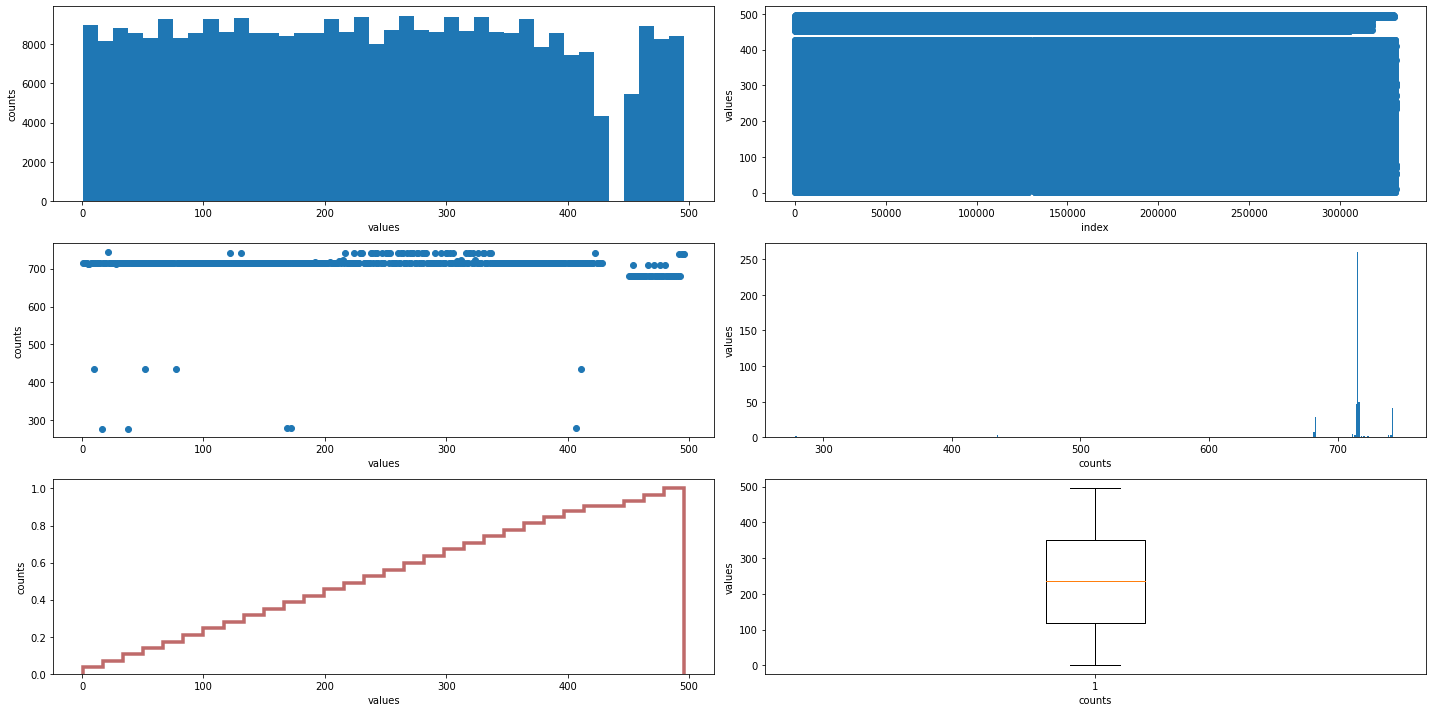

In [14]:
# station_id 
# Most values are repeated equally in the dataset
show_column_counts(dades_2019_Marc_tot, 'station_id')

## num_bikes_available

In [15]:
# num_bikes_available
# by looking at the differance between the 75% and max number 
# existance of outliers is possible. 54 is too big for a station size
# TODO, check max size of a station? Replace outliers with the maximum size
print(stats.describe(dades_2019_Marc_tot.num_bikes_available))
dades_2019_Marc_tot.num_bikes_available.describe()

DescribeResult(nobs=330740, minmax=(0.0, 53.54482758620689), mean=3.0796766412759955, variance=43.44904703553772, skewness=2.4645156462349265, kurtosis=5.884335882957972)


count    330740.000000
mean          3.079677
std           6.591589
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          53.544828
Name: num_bikes_available, dtype: float64

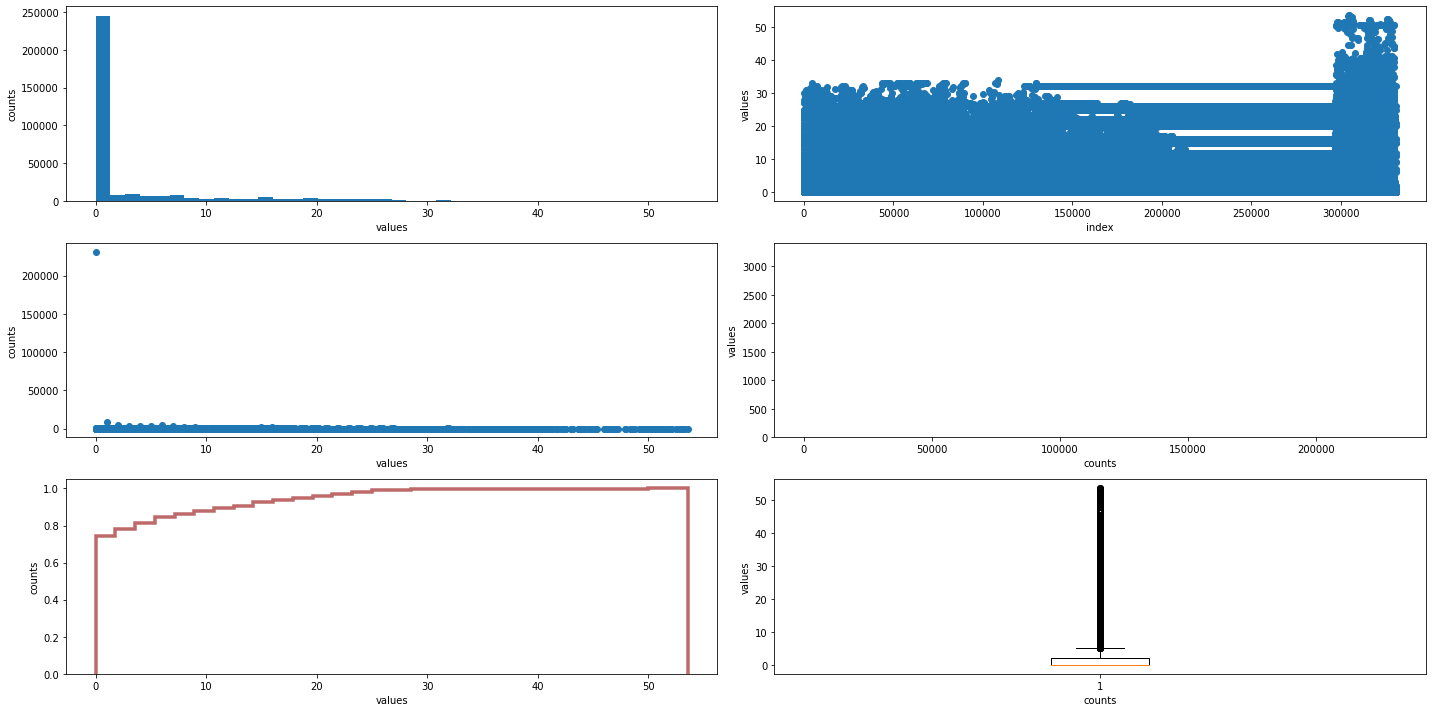

In [16]:
show_column_counts(dades_2019_Marc_tot, 'num_bikes_available')

## num_docks_available

In [17]:
print(stats.describe(dades_2019_Marc_tot.num_docks_available))
dades_2019_Marc_tot.num_docks_available.describe()

DescribeResult(nobs=330740, minmax=(0.0, 53.855172413793106), mean=21.125827994108644, variance=78.07631099845459, skewness=-0.8531617973807849, kurtosis=-0.11853314174829288)


count    330740.000000
mean         21.125828
std           8.836080
min           0.000000
25%          18.000000
50%          24.000000
75%          27.000000
max          53.855172
Name: num_docks_available, dtype: float64

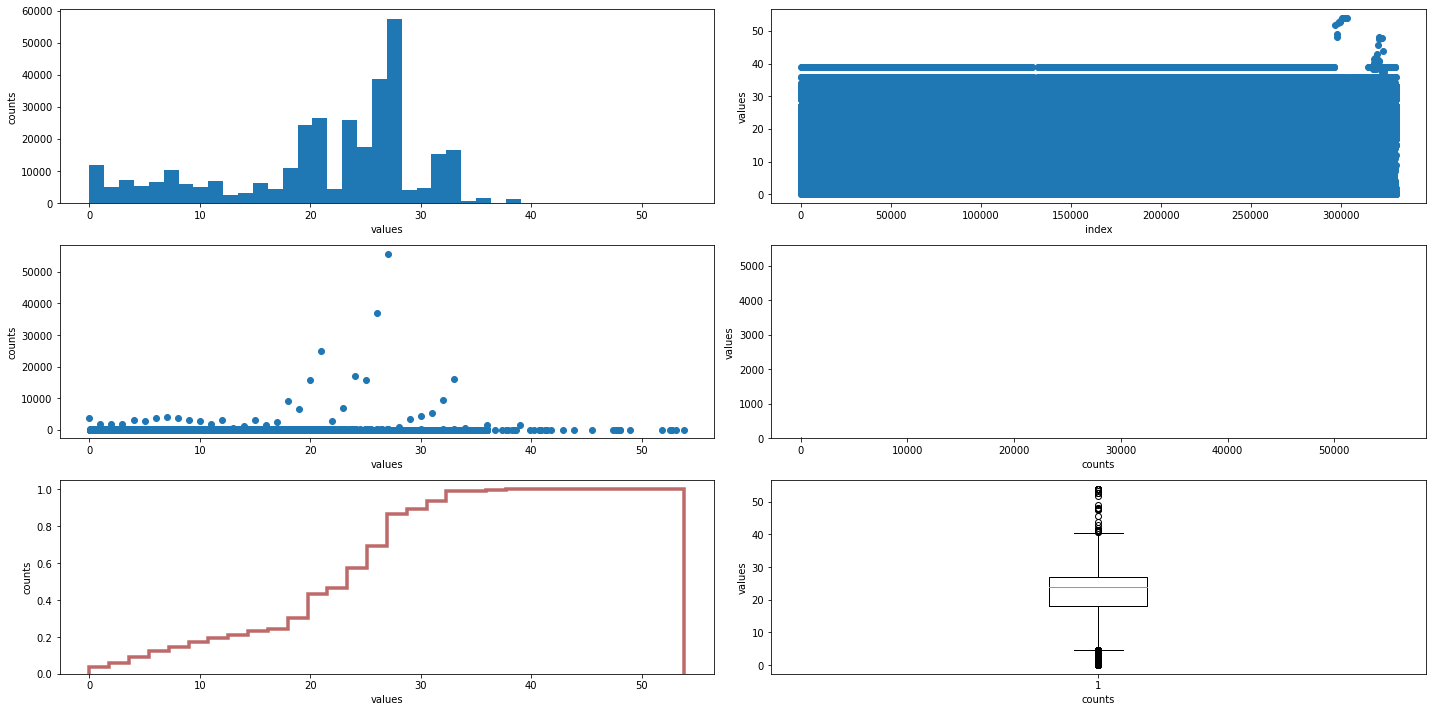

In [18]:
show_column_counts(dades_2019_Marc_tot, 'num_docks_available')

## capacity

In [19]:
print(stats.describe(dades_2019_Marc_tot.capacity))
dades_2019_Marc_tot.capacity.describe()

DescribeResult(nobs=330740, minmax=(0.0, 54.0), mean=24.436982189539364, variance=38.94084634143399, skewness=-0.817993700282427, kurtosis=1.9001100011914955)


count    330740.000000
mean         24.436982
std           6.240260
min           0.000000
25%          21.000000
50%          26.000000
75%          27.000000
max          54.000000
Name: capacity, dtype: float64

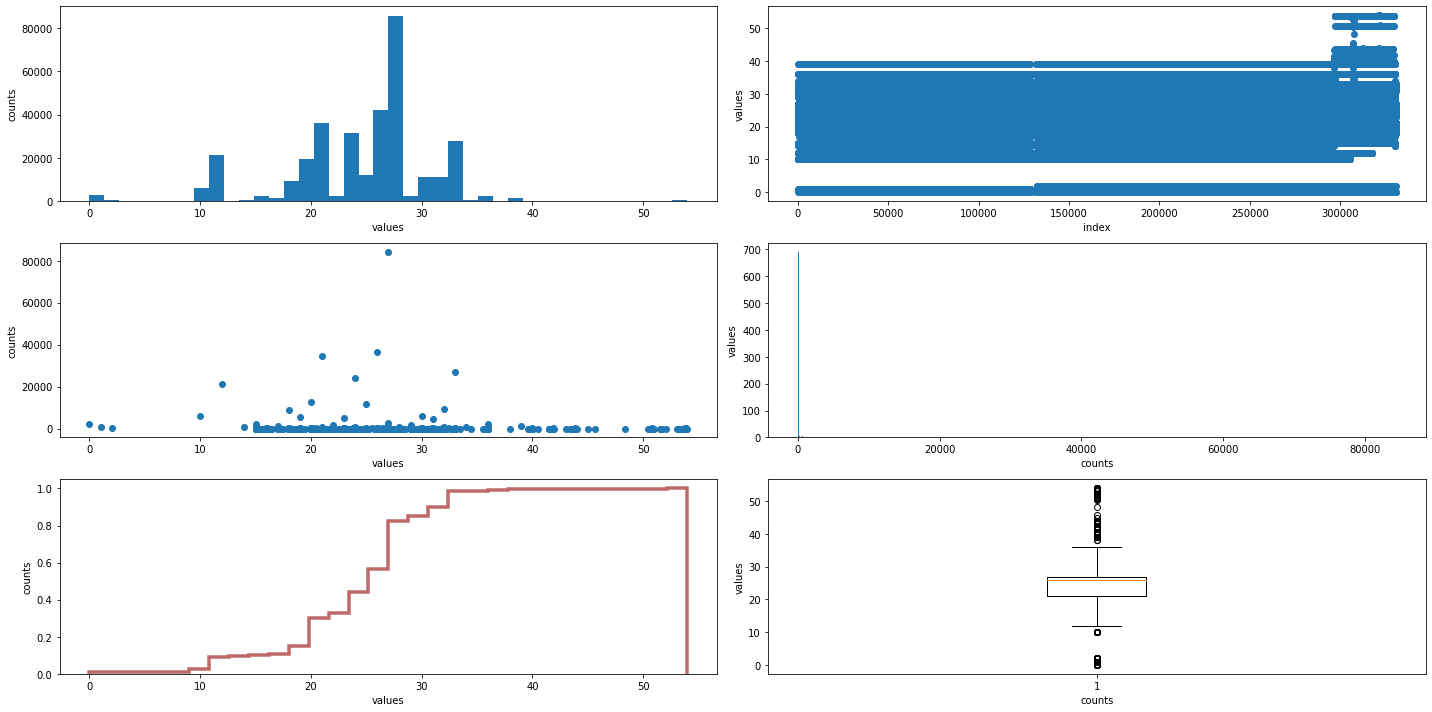

In [20]:
show_column_counts(dades_2019_Marc_tot, 'capacity')

## num_bikes_available_types.mechanical

In [21]:
print(stats.describe(dades_2019_Marc_tot['num_bikes_available_types.mechanical']))
dades_2019_Marc_tot['num_bikes_available_types.mechanical'].describe()

DescribeResult(nobs=330740, minmax=(0.0, 53.54482758620689), mean=3.0796766412759955, variance=43.44904703553772, skewness=2.4645156462349265, kurtosis=5.884335882957972)


count    330740.000000
mean          3.079677
std           6.591589
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          53.544828
Name: num_bikes_available_types.mechanical, dtype: float64

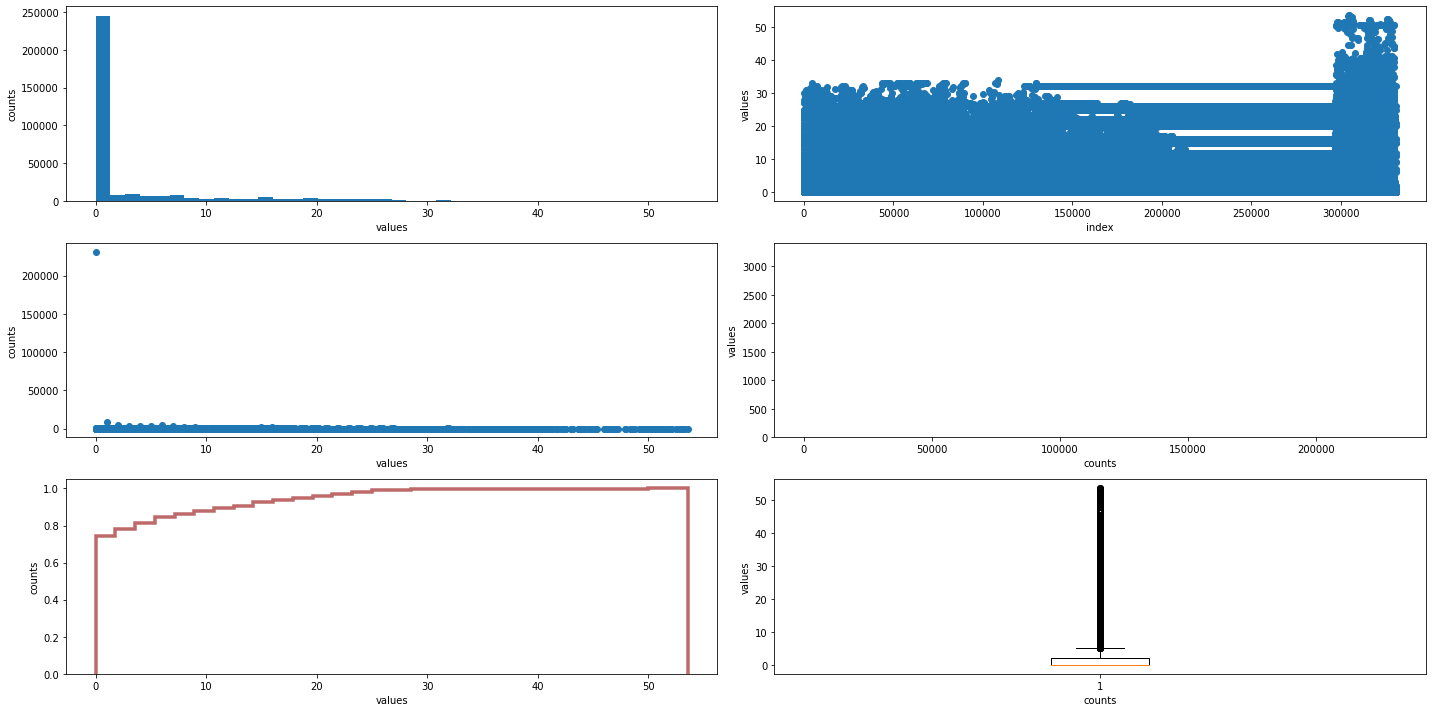

In [22]:
show_column_counts(dades_2019_Marc_tot, 'num_bikes_available_types.mechanical')

## num_bikes_available_types.ebike

In [23]:
print(stats.describe(dades_2019_Marc_tot['num_bikes_available_types.ebike']))
dades_2019_Marc_tot['num_bikes_available_types.ebike'].describe()

DescribeResult(nobs=330740, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)


count    330740.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: num_bikes_available_types.ebike, dtype: float64

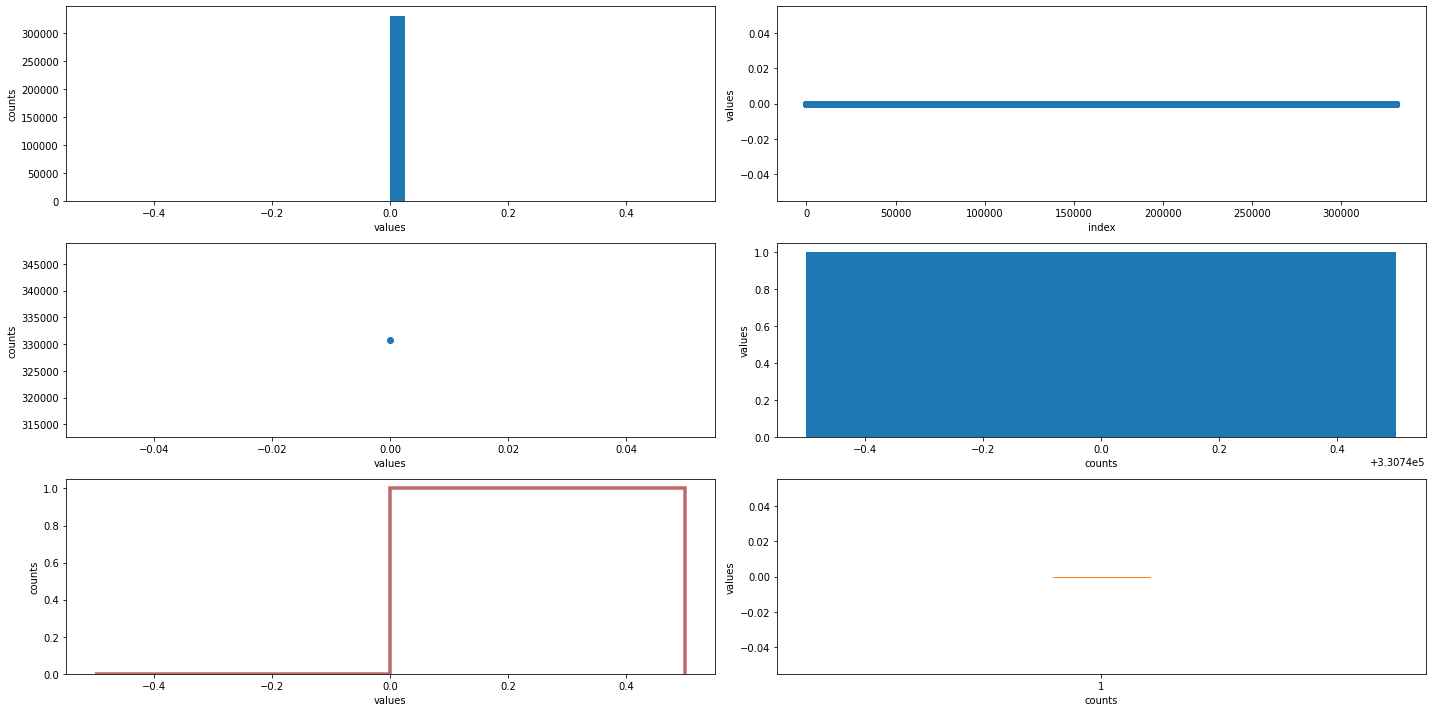

In [24]:
show_column_counts(dades_2019_Marc_tot, 'num_bikes_available_types.ebike')

## is_installed

In [25]:
print(stats.describe(dades_2019_Marc_tot.is_installed))
dades_2019_Marc_tot.is_installed.describe()

DescribeResult(nobs=330740, minmax=(1.0, 1.0), mean=1.0, variance=0.0, skewness=0.0, kurtosis=-3.0)


count    330740.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: is_installed, dtype: float64

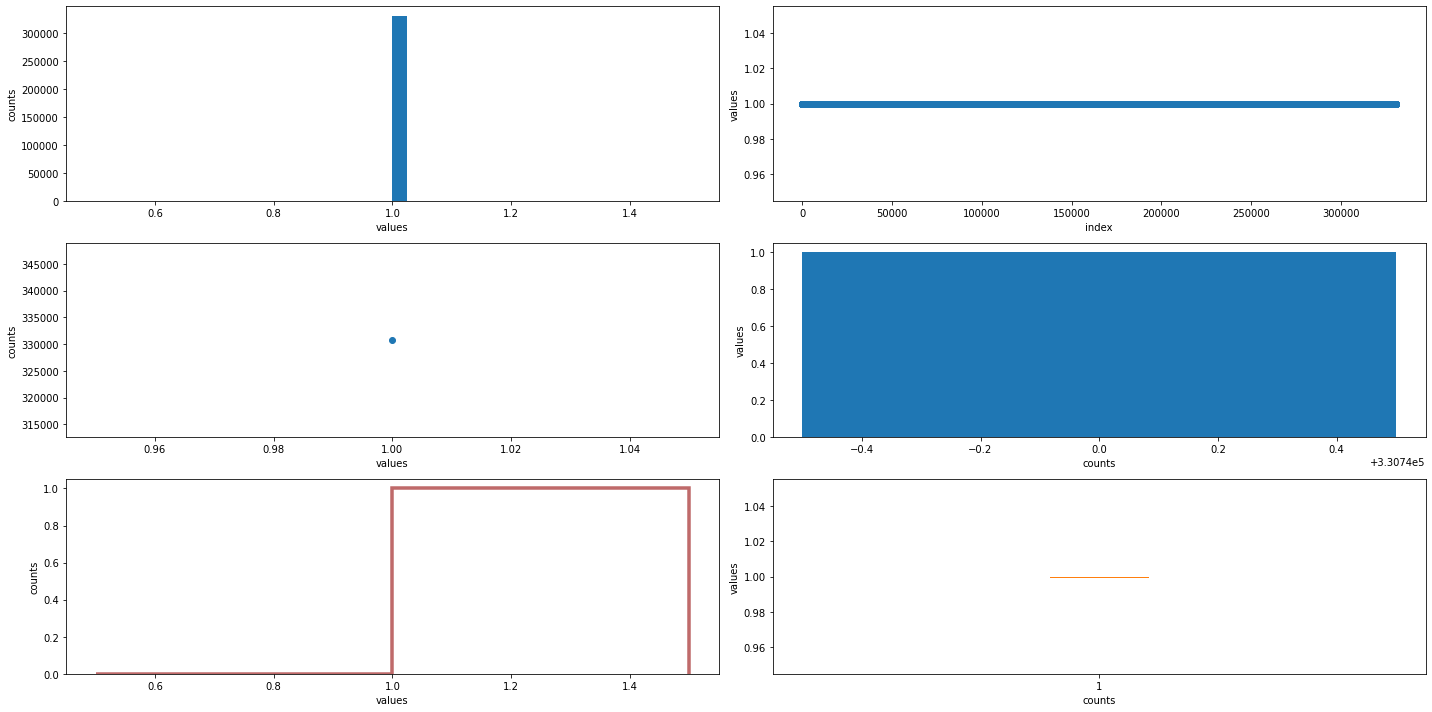

In [26]:
show_column_counts(dades_2019_Marc_tot, 'is_installed')

## is_renting

In [27]:
print(stats.describe(dades_2019_Marc_tot.is_renting))
dades_2019_Marc_tot.is_renting.describe()

DescribeResult(nobs=330740, minmax=(1.0, 1.0), mean=1.0, variance=0.0, skewness=0.0, kurtosis=-3.0)


count    330740.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: is_renting, dtype: float64

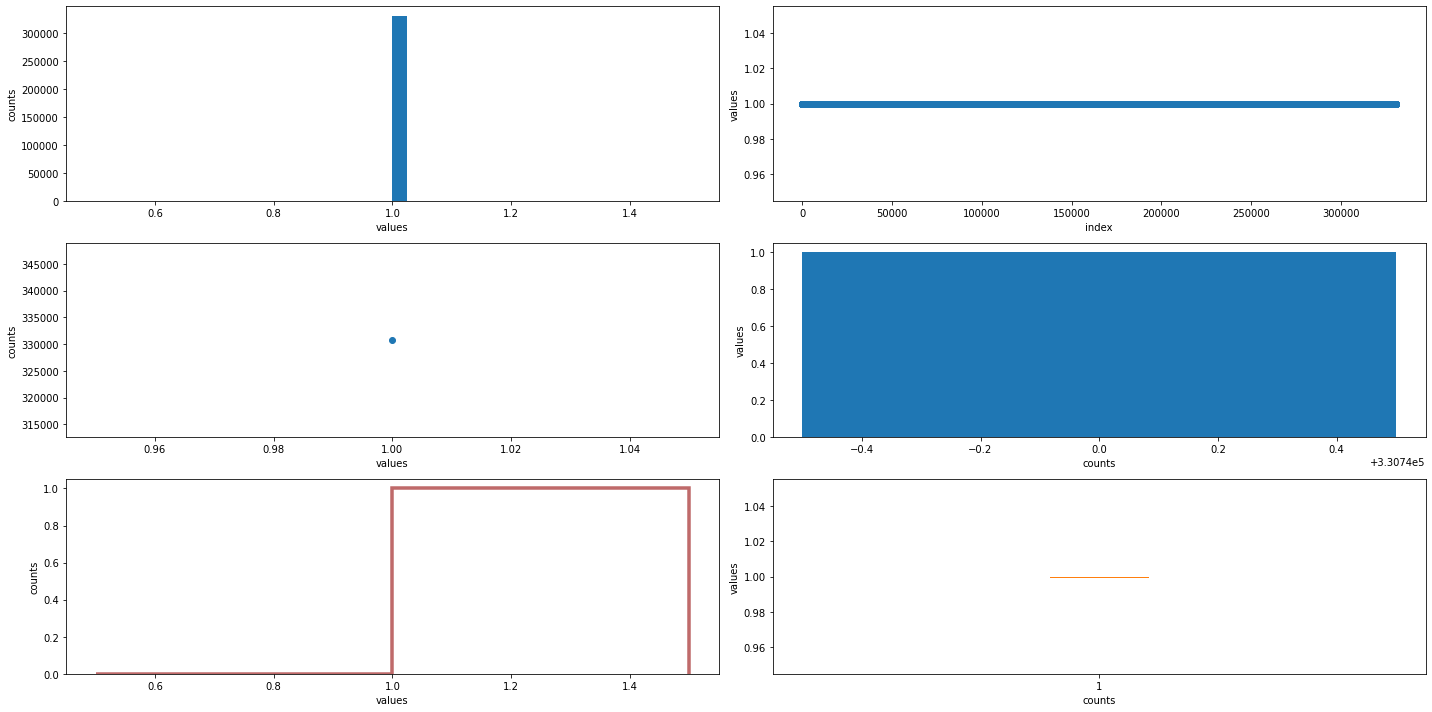

In [28]:
show_column_counts(dades_2019_Marc_tot, 'is_renting')

## is_returning

In [29]:
print(stats.describe(dades_2019_Marc_tot.is_returning))
dades_2019_Marc_tot.is_returning.describe()

DescribeResult(nobs=330740, minmax=(1.0, 1.0), mean=1.0, variance=0.0, skewness=0.0, kurtosis=-3.0)


count    330740.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: is_returning, dtype: float64

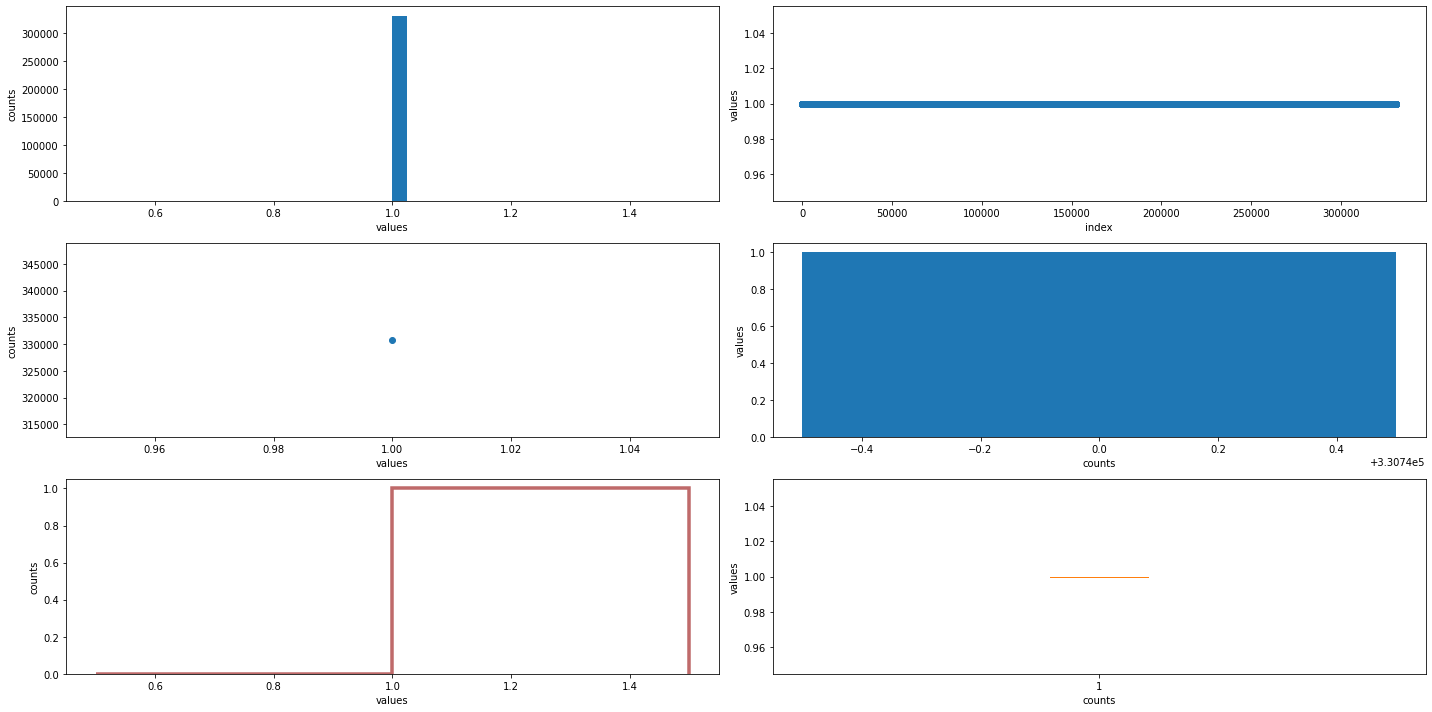

In [30]:
show_column_counts(dades_2019_Marc_tot, 'is_returning')

## is_charging_station

In [31]:
print(stats.describe(dades_2019_Marc_tot.is_charging_station))
dades_2019_Marc_tot.is_charging_station.describe()

DescribeResult(nobs=330740, minmax=(1.0, 1.0), mean=1.0, variance=0.0, skewness=0.0, kurtosis=-3.0)


count    330740.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: is_charging_station, dtype: float64

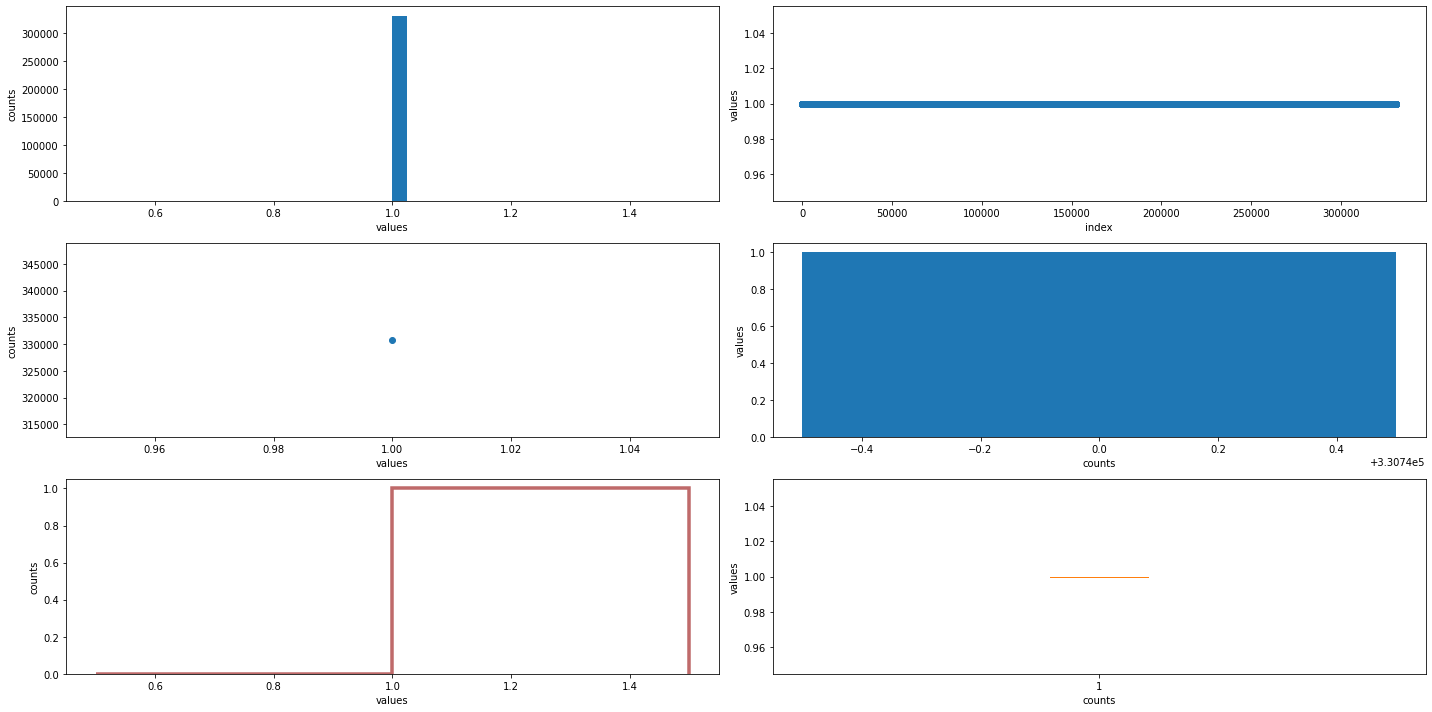

In [32]:
show_column_counts(dades_2019_Marc_tot, 'is_charging_station')

## status

In [33]:
print(stats.describe(dades_2019_Marc_tot.status))
dades_2019_Marc_tot.status.describe()

DescribeResult(nobs=330740, minmax=(0.0, 1.0), mean=0.25598072160614554, variance=0.18906514805233215, skewness=1.1139202213052375, kurtosis=-0.7544430125377684)


count    330740.000000
mean          0.255981
std           0.434816
min           0.000000
25%           0.000000
50%           0.000000
75%           0.991803
max           1.000000
Name: status, dtype: float64

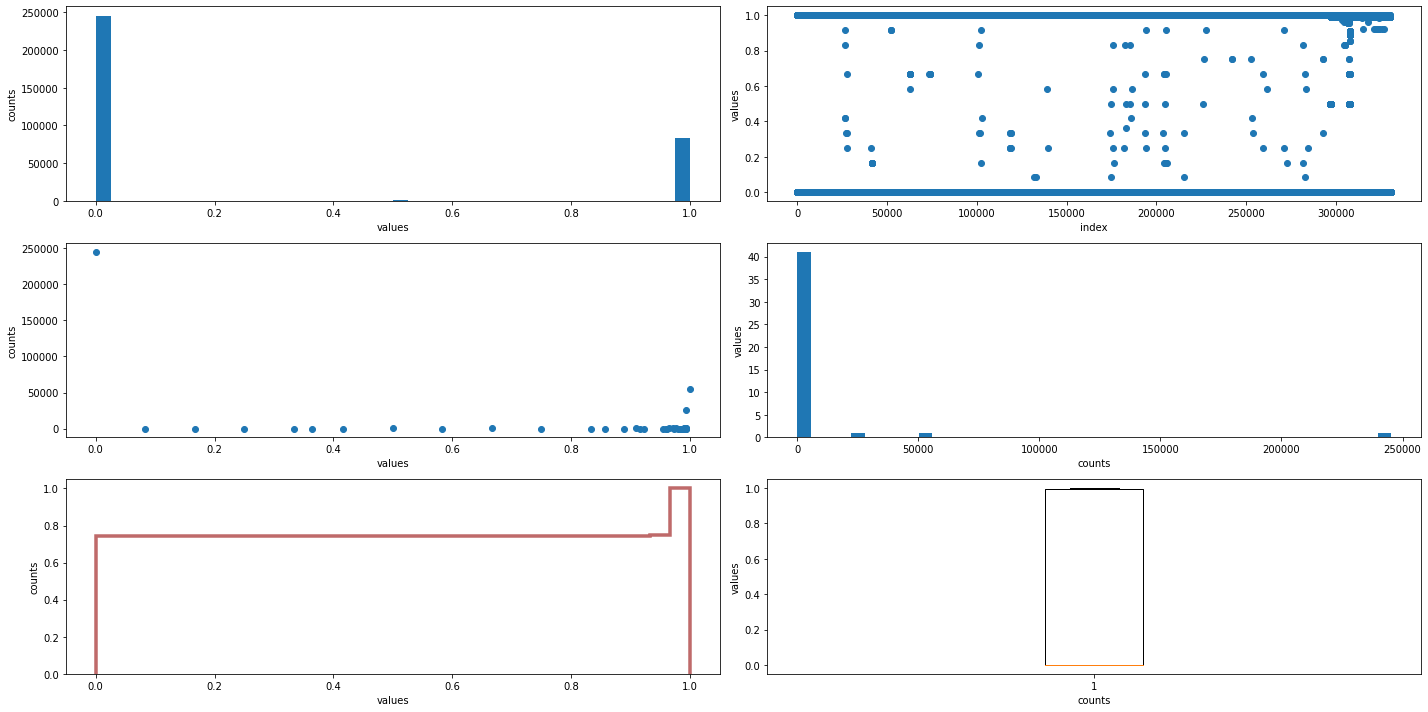

In [34]:
show_column_counts(dades_2019_Marc_tot, 'status')

## last_updated

In [35]:
print(stats.describe(dades_2019_Marc_tot.last_updated))
dades_2019_Marc_tot.last_updated.describe()

DescribeResult(nobs=330740, minmax=(1551394800.0, 1554073200.0), mean=1552734179.5972667, variance=610810202074.0292, skewness=-0.028837479341253417, kurtosis=-1.239897641203619)


count    3.307400e+05
mean     1.552734e+09
std      7.815435e+05
min      1.551395e+09
25%      1.552036e+09
50%      1.552766e+09
75%      1.553411e+09
max      1.554073e+09
Name: last_updated, dtype: float64

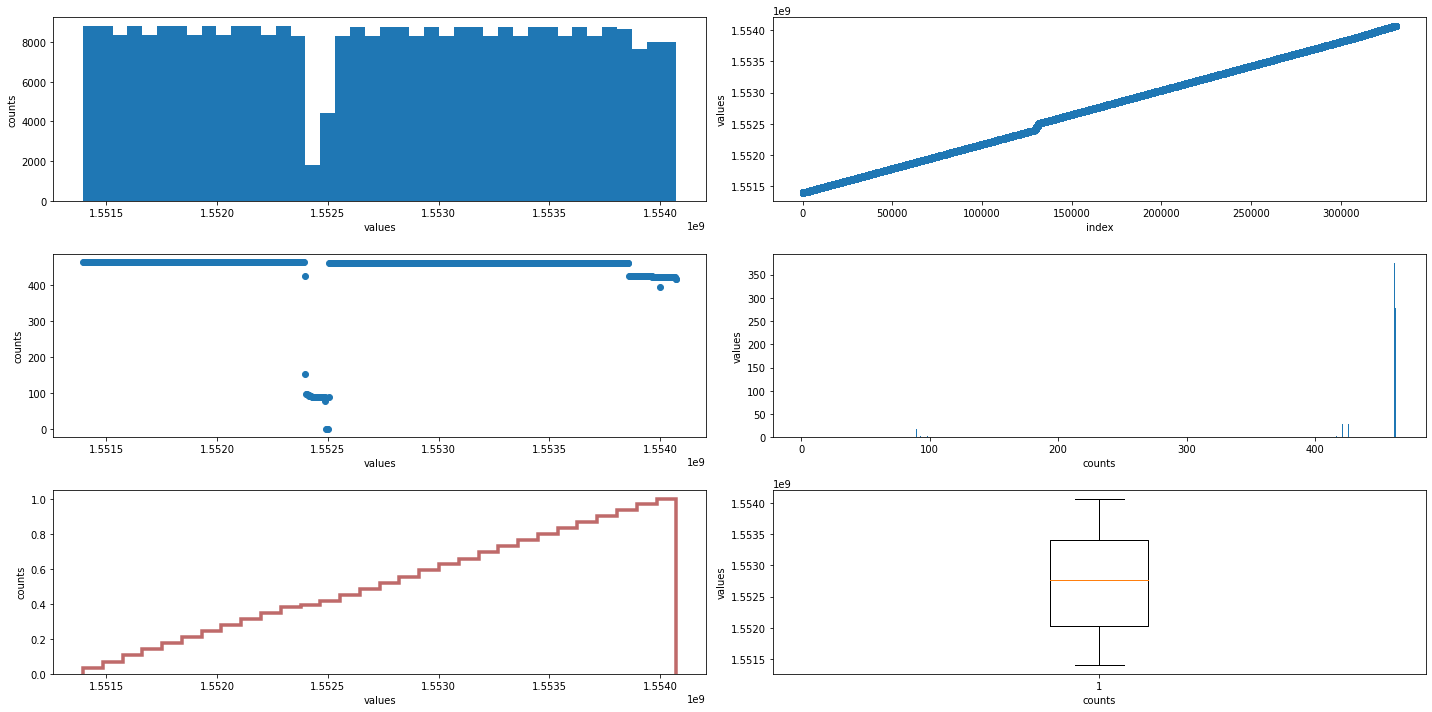

In [36]:
show_column_counts(dades_2019_Marc_tot, 'last_updated')

## physical_configuration

In [37]:
print(stats.describe(dades_2019_Marc_tot.physical_configuration))
dades_2019_Marc_tot.physical_configuration.describe()

DescribeResult(nobs=330740, minmax=(0.0, 1.0), mean=0.1834692672909151, variance=0.14848560400400074, skewness=1.6292973951621421, kurtosis=0.6616372283845466)


count    330740.000000
mean          0.183469
std           0.385338
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: physical_configuration, dtype: float64

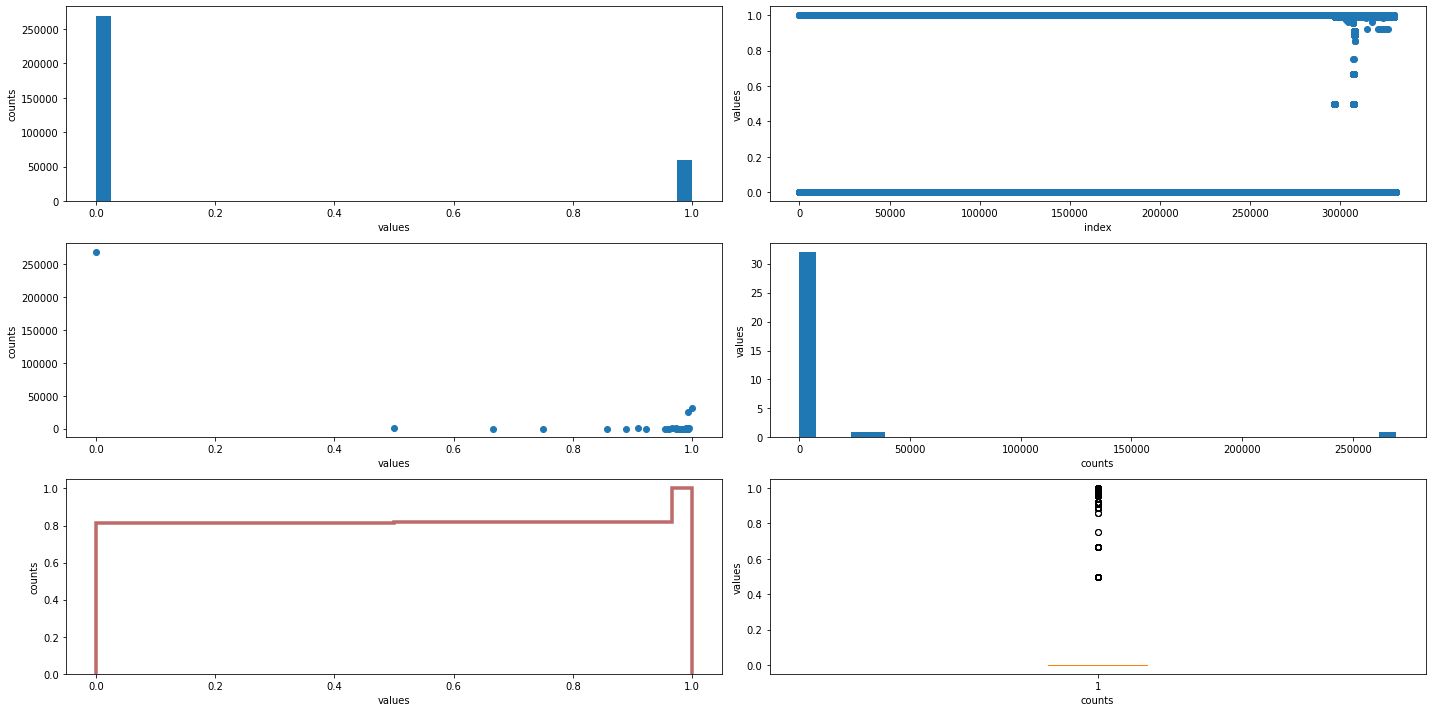

In [38]:
show_column_counts(dades_2019_Marc_tot, 'physical_configuration')

## altitude

In [39]:
print(stats.describe(dades_2019_Marc_tot.altitude))
dades_2019_Marc_tot.altitude.describe()

DescribeResult(nobs=330740, minmax=(0.0, 138.0), mean=32.36405244624772, variance=735.8255971535574, skewness=0.8399907680482717, kurtosis=0.5543755864753113)


count    330740.000000
mean         32.364052
std          27.126105
min           0.000000
25%          10.000000
50%          28.000000
75%          49.000000
max         138.000000
Name: altitude, dtype: float64

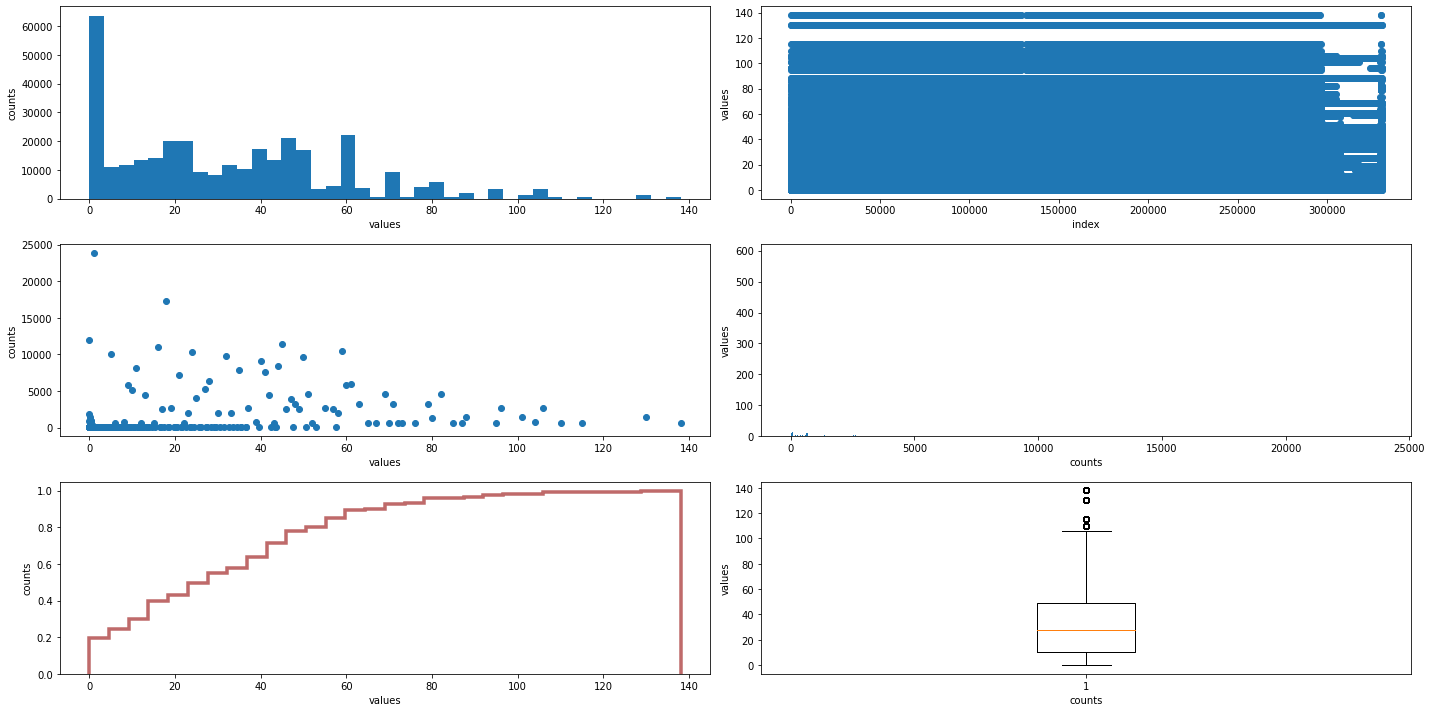

In [40]:
show_column_counts(dades_2019_Marc_tot, 'altitude')

## post_code

In [41]:
print(stats.describe(dades_2019_Marc_tot.post_code))
dades_2019_Marc_tot.post_code.describe()

DescribeResult(nobs=330740, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)


count    300905.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: post_code, dtype: float64

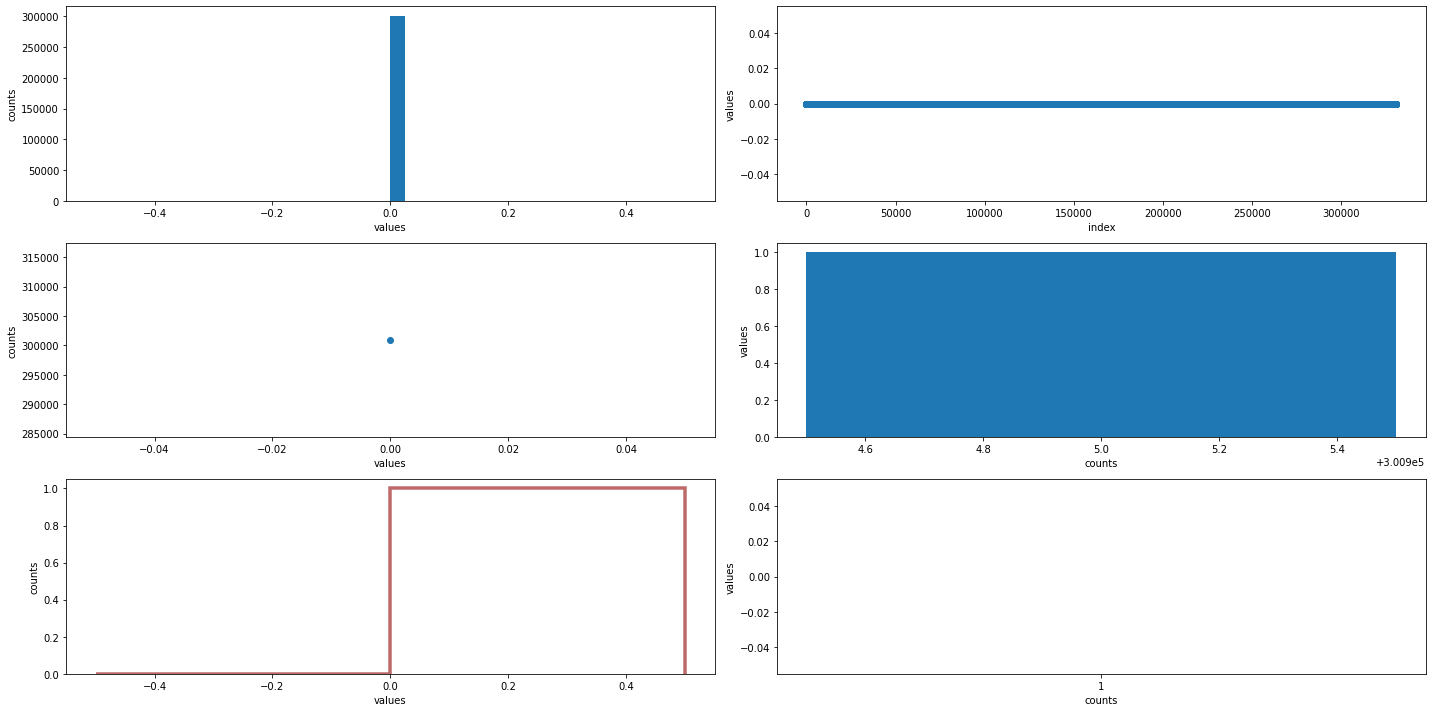

In [42]:
show_column_counts(dades_2019_Marc_tot, 'post_code')

## lat

In [43]:
print(stats.describe(dades_2019_Marc_tot.lat))
dades_2019_Marc_tot.lat.describe()

DescribeResult(nobs=330740, minmax=(41.357067, 41.45063400000001), mean=41.39654790162481, variance=0.00033580062545745913, skewness=0.677143488608711, kurtosis=0.03363329339352106)


count    330740.000000
mean         41.396548
std           0.018325
min          41.357067
25%          41.382822
50%          41.393512
75%          41.406086
max          41.450634
Name: lat, dtype: float64

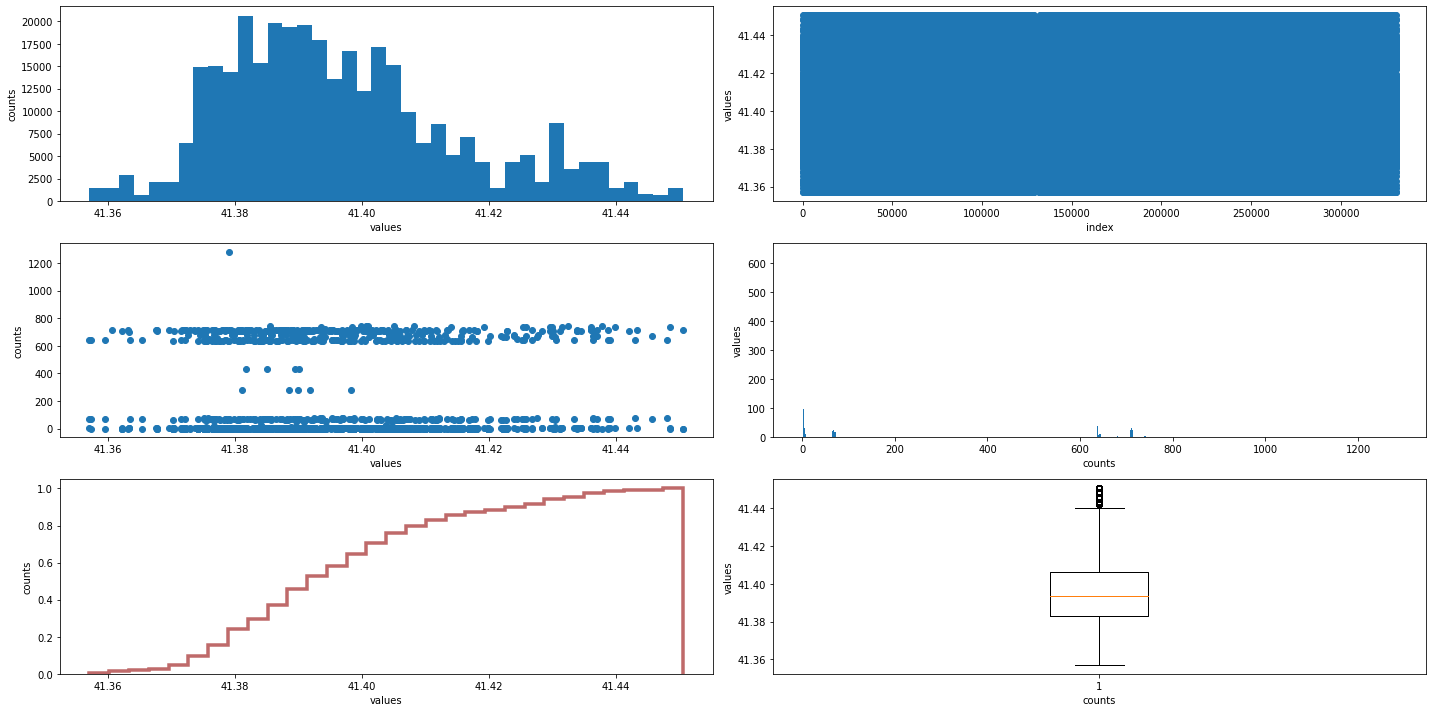

In [44]:
show_column_counts(dades_2019_Marc_tot, 'lat')

## lon

In [45]:
print(stats.describe(dades_2019_Marc_tot.lon))
dades_2019_Marc_tot.lon.describe()

DescribeResult(nobs=330740, minmax=(2.111615, 2.22123), mean=2.169300255299089, variance=0.000599634149226661, skewness=-0.27474113064380645, kurtosis=-0.7260215925889444)


count    330740.000000
mean          2.169300
std           0.024487
min           2.111615
25%           2.150764
50%           2.172667
75%           2.188217
max           2.221230
Name: lon, dtype: float64

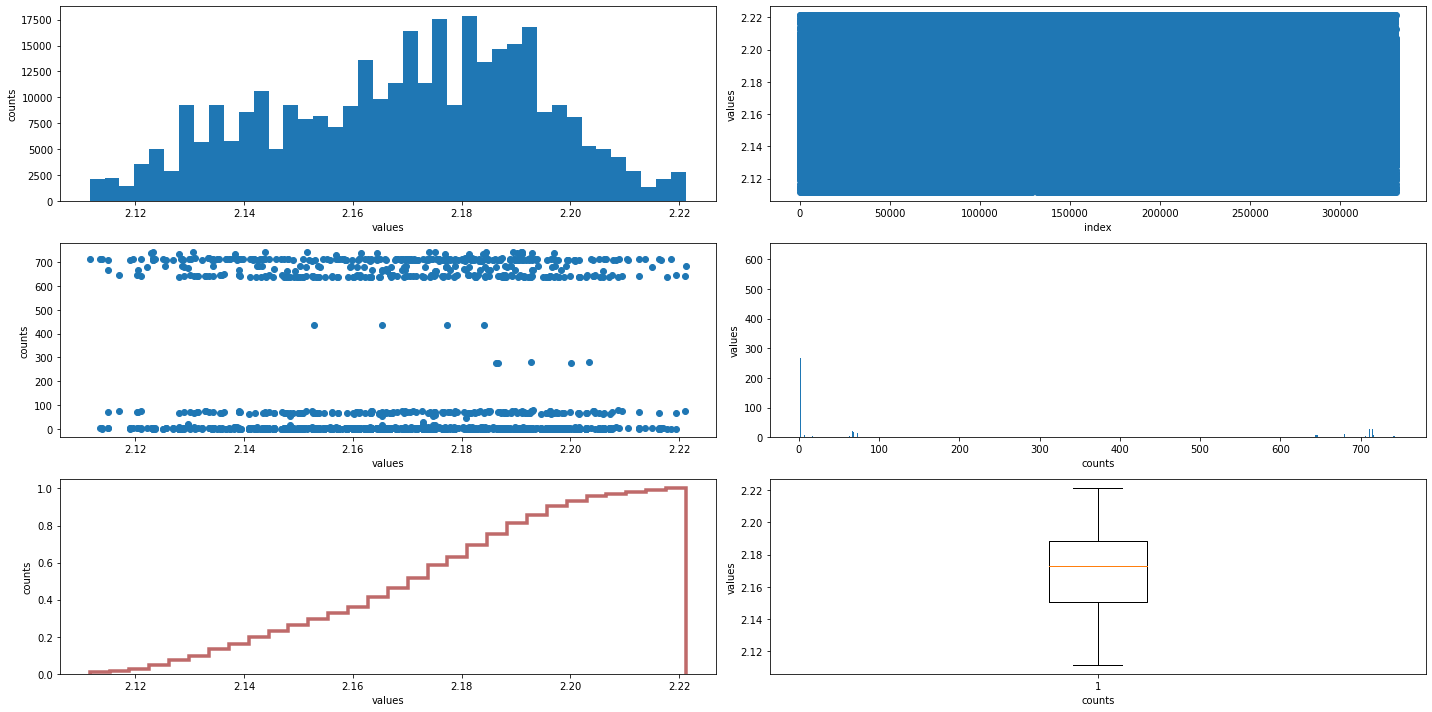

In [46]:
show_column_counts(dades_2019_Marc_tot, 'lon')